# History matching and ABC in sugarscape

A very brief description of sugarscape:
The environment grows sugar. The amount of sugar any location in the environment is capable of growing is in the range [0, 4].
Agents wander around harvesting sugar. The eat only what they need, and carry around any extra sugar they harvested.
After a location has been harvested, it regenerates its sugar by 1 each step in the simulation.
If there's not enough sugar in the agent's current location they try to move to a new location that has more sugar. They're limited in how far they can see and, therefore, how far they can move.
If they can't find enough sugar they die.


In [1]:
import numpy as np
import random
from time import strftime, time
import multiprocessing as mp
from tabulate import tabulate

from sugarscape_cg_simple.model import SugarscapeCg
import plot_sugarscape_env
import history_matching
import sugarscape_hm

Plot the sugarscape environment. Each space in the grid as an amount of sugar ranging between 0 and 4. This is the maximum amount of sugar that a given space can have at any time. The amount a space contains reduces as it is harvested, and grows back at a constant rate of 1 per time step in the simulation.

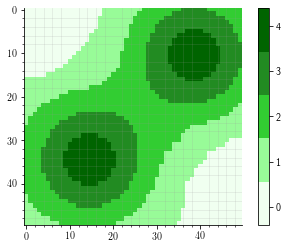

In [2]:
plot_sugarscape_env.plot()

## Exploring maximum metabolism

Each agent's metabolism is in the range [1,x] where x is the maximum possible metabolism an agent can have. The higher an agent's metabolism, the more food they need to eat to survive.
In this example, we'll explore what value of x is plausible.

The initial population in the model is 100 and agents die if there is not enough food---in fact, this is the only way they can die.
Our output of interest is: how many agents can the environment sustain?

In [3]:
def run_simulation(x):
    SS = SugarscapeCg(initial_population=100, max_metabolism=x)
    SS.verbose = False
    # the model is simple enough that 30 steps is sufficient to reach a steady population state
    y =  SS.run_model(step_count=30)
    return y  # total number of agents remaining in the simulation

We'll pretend one given run of the simulation is the "real world".
In this run, we set the maximum metabolism to be 4.

In [4]:
obs = run_simulation(4)

## History matching

First, let's run history matching to see what values of maximum metabolism are plausible.

In [5]:
history_matching.y = obs  # the real world observation
history_matching.f = run_simulation  # the function (simulation) used for history matching

def run_history_matching(new_plaus_space):
    plaus_space = []  # not yet explored
    while not history_matching.is_all_plausible(plaus_space, new_plaus_space):
        plaus_space = new_plaus_space
        new_plaus_space, implaus_scores, v_ens = history_matching.wave(plaus_space)
    print('Finished with', str(new_plaus_space))
    return new_plaus_space, v_ens

In [6]:
# initial plausible space to explore
# note that SugarscapeCg only takes integer values for metabolism
plaus_space = np.array(range(1, 5))
plaus_space, uncert = run_history_matching(plaus_space)

[1 2 3 4]
[3, 4]
Finished with [3, 4]


We started with the set [1, 2, 3, 4] as initial plausible values for maximum metabolism.
The history matching process narrowed this down to 3 and 4 being the only ones plausible.

## Approximate Bayesian Computation

Next, let's do some basic approximate bayesian computation to get posteriors for these two plausible values.

We have 100 particles and for each particle we randomly sample a value (in this case either 3 or 4) and run the simulation. If the error (absolute difference between simulation and "real world") is smaller than our uncertainty (in this case, uncertainty caused by ensemble variance) the sample is kept. If the error is larger than our uncertainty, we take another random sample for our metabolism parameter and retest (note that the new random sample chosen could coincidentally be the same value again).

In [7]:
# set parameters, specify functions and initialise storage objects
N = 100  # number of particles
theta = np.zeros(N)  # particle results
rho = lambda x,y: abs(x-y)  # measure of error

def abc(_):
    d = uncert + 1  # initialise d to be greater than the tolerance threshold
    while d > uncert:
        sample = plaus_space[random.randint(0, len(plaus_space)-1)]  # sample from the prior
        x = run_simulation(sample)  # get simulation result
        d = rho(obs, x)  # compute distance
    return sample  # store the accepted value

# run the algorithm
a = time()
pool = mp.Pool(mp.cpu_count())
theta = pool.map_async(abc, range(N)).get()
pool.close()
b = time()

# print results
print('Time taken (s):', str(round(b - a)))
print('Results:')
table = []
for x in plaus_space:
    table.append([x, theta.count(x)])
print(tabulate(table, headers=['parameter', 'posterior']))

Time taken (s): 59
Results:
  parameter    posterior
-----------  -----------
          3           55
          4           45


Out of 100 particles, the value 3 was found to be a suitable value 55 times, and the value 4 was found suitable 45 times.